In [1]:
import sys
import os
import random

import torch

import config
import pprint
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from pycocotools.coco import COCO
from shutil import copyfile
from torch.utils.data import random_split

In [2]:
sys.path.append('models/detection')
sys.path.append('models/detection/FasterRCNN')
sys.path.append('models/detection/YOLOv3')
sys.path.append('utils')

from models.detection.models import *
from utils.evaluate_utils import AdvDetectionMetrics, TrainWatcher
from utils.visualize_utils import draw_bbox_with_tensor, show
from utils.utils import PatternProjector, ToxicTargetsGenerator, log, LossManager, ResizeGroundTruth, set_seed
from adv_patch_generator import *
from data import coco_2017_dev_5k
from trainer import AdvPatchTrainer

In [3]:
from data import BoxNumSelector, TrafficScenesSelector, ComposeSelector

In [113]:
from models.detection.YOLOv3.utils.augmentations import *

In [102]:
from models.detection.YOLOv3.utils.datasets import ListDataset

In [129]:
AUGMENTATION_TRANSFORMS = transforms.Compose([
    AbsoluteLabels(),
    RelativeLabels(),
    ToTensor(),
])

In [130]:
data = ListDataset("data\\custom\\train.txt", transform=AUGMENTATION_TRANSFORMS, multiscale=False)

In [134]:
data[0]

('data/custom/images/train.jpg',
 tensor([[[0.4275, 0.3922, 0.4000,  ..., 0.5608, 0.5490, 0.5412],
          [0.4314, 0.3804, 0.3804,  ..., 0.5490, 0.5529, 0.5569],
          [0.4588, 0.4157, 0.4078,  ..., 0.4745, 0.4745, 0.4824],
          ...,
          [0.6118, 0.6235, 0.6235,  ..., 0.3451, 0.3255, 0.3059],
          [0.5843, 0.6353, 0.6706,  ..., 0.3765, 0.3608, 0.3451],
          [0.5882, 0.6392, 0.6941,  ..., 0.3961, 0.3843, 0.3725]],
 
         [[0.5725, 0.5373, 0.5451,  ..., 0.6588, 0.6431, 0.6275],
          [0.5765, 0.5255, 0.5255,  ..., 0.6549, 0.6471, 0.6431],
          [0.5922, 0.5608, 0.5529,  ..., 0.5882, 0.5804, 0.5765],
          ...,
          [0.4745, 0.4745, 0.4667,  ..., 0.4706, 0.4392, 0.4196],
          [0.4471, 0.4863, 0.5137,  ..., 0.4902, 0.4745, 0.4588],
          [0.4392, 0.4902, 0.5373,  ..., 0.5098, 0.4980, 0.4863]],
 
         [[0.6078, 0.5725, 0.5804,  ..., 0.6863, 0.6824, 0.6706],
          [0.6118, 0.5608, 0.5608,  ..., 0.6824, 0.6863, 0.6941],
       

In [135]:
dl = torch.utils.data.DataLoader(data, batch_size=2, collate_fn=data.collate_fn)

In [174]:
for _, X, y in dl:
    break

In [179]:
y

tensor([[0.0000, 0.0000, 0.5150, 0.5000, 0.2169, 0.1829],
        [0.0000, 2.0000, 0.5000, 0.5000, 0.5000, 0.5000],
        [0.0000, 1.0000, 0.3000, 0.3000, 0.3000, 0.4000],
        [1.0000, 2.0000, 0.0000, 0.0000, 1.0000, 0.9000]])

In [142]:
ds1, ds2 = coco_2017_dev_5k(requires_val=True, split_rate=[20, 30], data_selectors=[None, None])

loading annotations into memory...
Done (t=0.81s)
creating index...
index created!


Selecting data: 100%|██████████| 5000/5000 [00:00<00:00, 833095.78it/s]


In [143]:
ds1[1]

(tensor([[[0.7961, 0.8784, 0.6745,  ..., 0.9725, 0.9922, 0.9059],
          [0.7961, 0.7882, 0.7569,  ..., 1.0000, 0.9529, 0.9412],
          [0.7765, 0.6471, 0.8510,  ..., 0.9882, 0.9490, 0.9255],
          ...,
          [0.9176, 0.8314, 0.4588,  ..., 0.4549, 0.9216, 0.8627],
          [0.7608, 0.7176, 0.7529,  ..., 0.3686, 0.8431, 0.9882],
          [0.7098, 0.7216, 0.8235,  ..., 0.3608, 0.5922, 0.9176]],
 
         [[0.7333, 0.8667, 0.7569,  ..., 1.0000, 0.9686, 0.9451],
          [0.7569, 0.8980, 0.8039,  ..., 0.9804, 0.9765, 0.9843],
          [0.8706, 0.8039, 0.7725,  ..., 0.9961, 0.9490, 0.9843],
          ...,
          [0.6824, 0.6941, 0.2510,  ..., 0.4235, 0.7294, 0.6510],
          [0.5686, 0.4863, 0.5647,  ..., 0.2078, 0.7843, 0.8000],
          [0.5216, 0.4784, 0.5843,  ..., 0.1294, 0.4392, 0.6627]],
 
         [[0.7725, 0.9412, 0.8235,  ..., 0.9333, 0.9765, 0.9098],
          [0.7608, 0.9412, 0.8510,  ..., 1.0000, 0.9686, 0.9216],
          [0.9647, 0.8000, 0.8078,  ...,

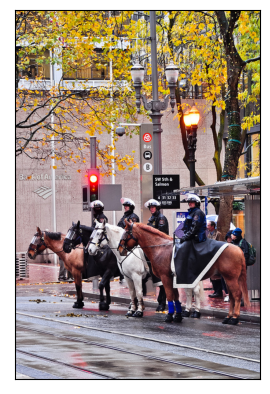

In [17]:
show(ds2[10][0])

In [150]:
model((ds1[0][0],))

({'boxes': tensor([[518.2150, 173.3004, 633.1882, 388.6255],
          [326.8954, 176.7054, 398.6180, 378.3262],
          [  7.7798, 163.7820, 128.1254, 403.9181],
          [340.4908,  44.5045, 413.8055, 110.6645],
          [566.4528,  89.2671, 640.8137, 159.3655]]),
  'labels': tensor([ 1,  1,  1, 10, 28], dtype=torch.int32),
  'scores': tensor([0.9991, 0.9988, 0.9915, 0.7214, 0.6120])},)

In [151]:
cats = coco.COCO(config.annotation_path).cats
labels_frcnn2yolo = {key: i for i, key in enumerate(cats.keys())}
labels_yolo2frcnn = {i: key for i, key in enumerate(cats.keys())}

loading annotations into memory...
Done (t=0.49s)
creating index...
index created!


In [168]:
def _yolo_target_trans(input_size=(416, 416), targets: Tuple[Dict[str, torch.Tensor]] = None):
    device = targets[0]['boxes'].device
    yolo_targets = []
    resizer = ResizeGroundTruth(input_size)
    for i, target in enumerate(targets):
        target = resizer(target)
        trans_target = torch.concat([
            torch.tensor([i], device=device, requires_grad=False).broadcast_to((target['boxes'].shape[0], 1)),
            target['labels'].unsqueeze(dim=1).cpu().apply_(
                lambda x: labels_frcnn2yolo[x] if labels_frcnn2yolo else x).to(device),
            box_convert(target['boxes'], 'xyxy', 'cxcywh')
        ], dim=1)
        print(trans_target)
        trans_target[:, [-4, -2]] /= input_size[0]
        trans_target[:, [-3, -1]] /= input_size[1]

        yolo_targets.append(trans_target)

    return torch.cat(yolo_targets, dim=0).to(device)

In [160]:
ds1[0][1]

{'boxes': tensor([[326.2800, 174.5600, 397.5200, 371.8100],
         [  9.7900, 167.0600, 131.7300, 393.5100],
         [510.4400, 171.2700, 634.1000, 387.0300],
         [560.7300,  90.2500, 640.0000, 157.5700],
         [ 46.0100, 211.1100,  79.5600, 262.9600],
         [345.1300, 226.4100, 356.1900, 248.5500],
         [337.0600,  44.1100, 398.4200, 101.2800]]),
 'labels': tensor([ 1,  1,  1, 28, 31, 47, 10]),
 'image_id': tensor([252219]),
 'origin_size': tensor([640, 428])}

In [161]:
labels_frcnn2yolo

{1: 0,
 2: 1,
 3: 2,
 4: 3,
 5: 4,
 6: 5,
 7: 6,
 8: 7,
 9: 8,
 10: 9,
 11: 10,
 13: 11,
 14: 12,
 15: 13,
 16: 14,
 17: 15,
 18: 16,
 19: 17,
 20: 18,
 21: 19,
 22: 20,
 23: 21,
 24: 22,
 25: 23,
 27: 24,
 28: 25,
 31: 26,
 32: 27,
 33: 28,
 34: 29,
 35: 30,
 36: 31,
 37: 32,
 38: 33,
 39: 34,
 40: 35,
 41: 36,
 42: 37,
 43: 38,
 44: 39,
 46: 40,
 47: 41,
 48: 42,
 49: 43,
 50: 44,
 51: 45,
 52: 46,
 53: 47,
 54: 48,
 55: 49,
 56: 50,
 57: 51,
 58: 52,
 59: 53,
 60: 54,
 61: 55,
 62: 56,
 63: 57,
 64: 58,
 65: 59,
 67: 60,
 70: 61,
 72: 62,
 73: 63,
 74: 64,
 75: 65,
 76: 66,
 77: 67,
 78: 68,
 79: 69,
 80: 70,
 81: 71,
 82: 72,
 84: 73,
 85: 74,
 86: 75,
 87: 76,
 88: 77,
 89: 78,
 90: 79}

In [167]:
box_convert(torch.tensor([10, 180, 130, 400]), 'xyxy', 'cxcywh')

tensor([ 70., 290., 120., 220.])

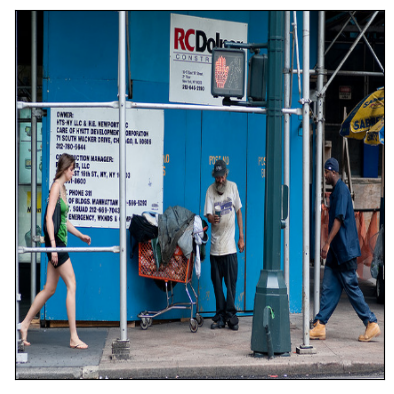

In [169]:
show(transforms.Resize((416, 416))(ds1[0][0]))

In [170]:
_yolo_target_trans(targets=(ds1[0][1],))

tensor([[  0.0000,   0.0000, 235.2350, 265.5256,  46.3060, 191.7196],
        [  0.0000,   0.0000,  45.9940, 272.4265,  79.2610, 220.1009],
        [  0.0000,   0.0000, 371.9755, 271.3234,  80.3790, 209.7106],
        [  0.0000,  25.0000, 390.2373, 120.4359,  51.5255,  65.4325],
        [  0.0000,  26.0000,  40.8102, 230.3891,  21.8075,  50.3962],
        [  0.0000,  41.0000, 227.9290, 230.8217,   7.1890,  21.5193],
        [  0.0000,   9.0000, 239.0310,  70.6568,  39.8840,  55.5671]])


tensor([[0.0000e+00, 0.0000e+00, 5.6547e-01, 6.3828e-01, 1.1131e-01, 4.6086e-01],
        [0.0000e+00, 0.0000e+00, 1.1056e-01, 6.5487e-01, 1.9053e-01, 5.2909e-01],
        [0.0000e+00, 0.0000e+00, 8.9417e-01, 6.5222e-01, 1.9322e-01, 5.0411e-01],
        [0.0000e+00, 2.5000e+01, 9.3807e-01, 2.8951e-01, 1.2386e-01, 1.5729e-01],
        [0.0000e+00, 2.6000e+01, 9.8102e-02, 5.5382e-01, 5.2422e-02, 1.2114e-01],
        [0.0000e+00, 4.1000e+01, 5.4791e-01, 5.5486e-01, 1.7281e-02, 5.1729e-02],
        [0.0000e+00, 9.0000e+00, 5.7459e-01, 1.6985e-01, 9.5875e-02, 1.3357e-01]])

In [144]:
model = yolo_v3()
model.eval()

loading annotations into memory...
Done (t=0.71s)
creating index...
index created!


_FasterRCNN_Like_YOLO(
  (yolo_model): Darknet(
    (module_list): ModuleList(
      (0): Sequential(
        (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (leaky_0): LeakyReLU(negative_slope=0.1)
      )
      (1): Sequential(
        (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (leaky_1): LeakyReLU(negative_slope=0.1)
      )
      (2): Sequential(
        (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (leaky_2): LeakyReLU(negative_slope=0.1)
      )
      (3): Sequential(
        (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding

In [6]:
model.train()

_FasterRCNN_Like_YOLO(
  (yolo_model): Darknet(
    (module_list): ModuleList(
      (0): Sequential(
        (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (leaky_0): LeakyReLU(negative_slope=0.1)
      )
      (1): Sequential(
        (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (leaky_1): LeakyReLU(negative_slope=0.1)
      )
      (2): Sequential(
        (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (leaky_2): LeakyReLU(negative_slope=0.1)
      )
      (3): Sequential(
        (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding

In [9]:
DS[i][1]

NameError: name 'i' is not defined

In [7]:
i = 2
loss = 0
model((DS[i][0], DS[i + 1][0]), (DS[i][1], DS[i + 1][1]))

{'loss_box_reg': tensor(0.0815, grad_fn=<SelectBackward0>),
 'loss_objectness': tensor(0.0711, grad_fn=<SelectBackward0>),
 'loss_classifier': tensor(0.0063, grad_fn=<SelectBackward0>),
 'atk_loss_box_reg': None,
 'atk_loss_objectness': None,
 'atk_loss_classifier': None}

In [ ]:
loss.backward()

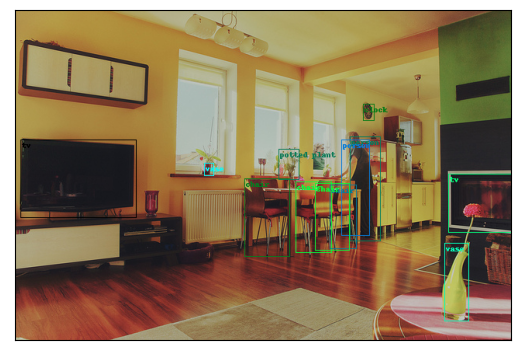

In [12]:
i = 0
model.eval()
preds = model((DS[i][0],))[0]
show(draw_bbox_with_tensor(DS[i][0], preds['boxes'], get_str_labels(preds['labels'])))

In [ ]:
traffic_objects = {2: 'bicycle', 3: 'car', 4: 'motorcycle', 6: 'bus', 8: 'truck', 10: 'traffic light', 13: 'stop sign', 14: 'parking meter'}

In [5]:
cats

{1: {'supercategory': 'person', 'id': 1, 'name': 'person'},
 2: {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'},
 3: {'supercategory': 'vehicle', 'id': 3, 'name': 'car'},
 4: {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'},
 5: {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'},
 6: {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'},
 7: {'supercategory': 'vehicle', 'id': 7, 'name': 'train'},
 8: {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'},
 9: {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'},
 10: {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'},
 11: {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'},
 13: {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'},
 14: {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'},
 15: {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'},
 16: {'supercategory': 'animal', 'id': 16, 'name': 'bird'},
 17: {'supercategory': 'animal', 'id': 17, 'name': 'cat'},

In [4]:
device = 'cuda'
# patch = torch.load('Exps/07-11-16-29/Data/patch.pt')
cats = COCO(config.annotation_path).cats


def get_str_labels(int_labels):
    str_labels = []
    if isinstance(int_labels, int):
        int_labels = [int_labels]
    for label in int_labels:
        str_labels.append(cats[int(label)]['name'])
    return str_labels

loading annotations into memory...
Done (t=0.75s)
creating index...
index created!


In [10]:
net2attack = fasterrcnn_mobilenet_v3_large_320_fpn_COCO().to(device)
net2attack.eval()
DS = coco_2017_dev_5k(config.folder_path, config.annotation_path, None, None)

loading annotations into memory...
Done (t=0.61s)
creating index...
index created!


In [20]:
image_idx = 10
projector = PatternProjector(pattern_posi=(0, 0), pattern_scale=(0.9, 1.1), rotation_angle=(-10, 10), mix_rate=(0.9, 0.99), min_luminance=0.0, luminance_smooth_boundary=None)

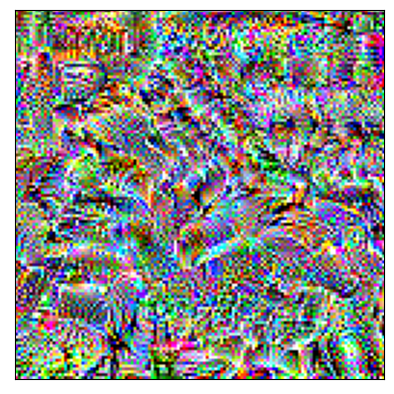

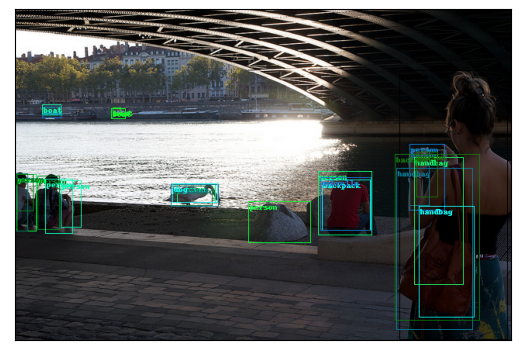

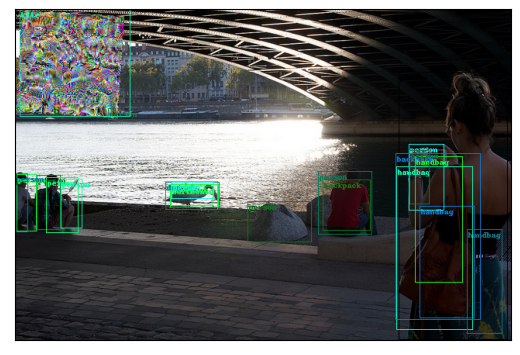

In [21]:
img = [DS[image_idx][0].to(device) for image_idx in (image_idx if isinstance(image_idx, (list, tuple)) else [image_idx])][0]
img_with_patch, pattern, (_, _) = projector(img.clone(), patch)

preds_clean_img = net2attack((img,))
boxes_clean_img = preds_clean_img[0]['boxes']
int_labels_clean_image = preds_clean_img[0]['labels']
str_labels_clean_image = get_str_labels(int_labels_clean_image)
example_image_clean = draw_bbox_with_tensor(img=img, bbox=boxes_clean_img, label=str_labels_clean_image)

preds_with_patch = net2attack((projector(img, patch.to(device))[0],))
boxes_with_patch = preds_with_patch[0]['boxes']
int_labels_with_patch = preds_with_patch[0]['labels']
str_labels_with_patch = get_str_labels(int_labels_with_patch)
example_with_patch = draw_bbox_with_tensor(img=img, bbox=boxes_with_patch, label=str_labels_with_patch)

show(patch)
show(example_image_clean)
show(example_with_patch)